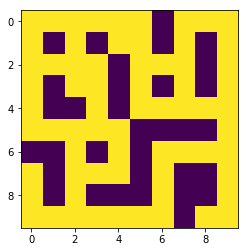

In [69]:
# Random Maze Generator using Depth-first Search
# http://en.wikipedia.org/wiki/Maze_generation_algorithm
# FB36 - 20130106
import random
import matplotlib.pyplot as plt
import numpy as np

imgx = 10; imgy = 10
image = Image.new("RGB", (imgx, imgy))
pixels = image.load()
mx = 10; my = 10 # width and height of the maze
maze = [[0 for x in range(mx)] for y in range(my)]
dx = [0, 1, 0, -1]; dy = [-1, 0, 1, 0] # 4 directions to move in the maze
color = [(0, 0, 0), (255, 255, 255)] # RGB colors of the maze
# start the maze from a random cell
cx = random.randint(0, mx - 1); cy = random.randint(0, my - 1)
maze[cy][cx] = 1; stack = [(cx, cy, 0)] # stack element: (x, y, direction)

while len(stack) > 0:
    (cx, cy, cd) = stack[-1]
    # to prevent zigzags:
    # if changed direction in the last move then cannot change again
    if len(stack) > 2:
        if cd != stack[-2][2]: dirRange = [cd]
        else: dirRange = range(4)
    else: dirRange = range(4)

    # find a new cell to add
    nlst = [] # list of available neighbors
    for i in dirRange:
        nx = cx + dx[i]; ny = cy + dy[i]
        if nx >= 0 and nx < mx and ny >= 0 and ny < my:
            if maze[ny][nx] == 0:
                ctr = 0 # of occupied neighbors must be 1
                for j in range(4):
                    ex = nx + dx[j]; ey = ny + dy[j]
                    if ex >= 0 and ex < mx and ey >= 0 and ey < my:
                        if maze[ey][ex] == 1: ctr += 1
                if ctr == 1: nlst.append(i)

    # if 1 or more neighbors available then randomly select one and move
    if len(nlst) > 0:
        ir = nlst[random.randint(0, len(nlst) - 1)]
        cx += dx[ir]; cy += dy[ir]; maze[cy][cx] = 1
        stack.append((cx, cy, ir))
    else: stack.pop()

for i in range(len(maze)):
    for j in range(len(maze[i])):
        if(random.random() > 0.8 and maze[i][j] == 0):
            maze[i][j] = 1
    

maze = np.array(maze)
plt.imshow(maze)
plt.show()  
maze = 1-maze
"""
maze = [[0 0 0 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 1 0 1 0 1 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0]
 [1 1 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 1 1 0]
 [0 1 0 1 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 0 0]]
 """


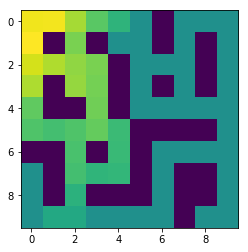

0.1399847937864787
0.2865638644601136


In [120]:
from scipy.stats import entropy

actions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
def is_valid(state, maze):
    if(state[0] >= len(maze) or state[1] >= len(maze[0]) \
       or state[0] < 0 or state[1] < 0 or maze[state[0]][state[1]] == 1): 
        return False
    else:
        return True

def get_distance_map(maze, goal):
    distance_map = [[float("inf")] * len(maze[0]) for _ in maze]
    distance_map[goal[0]][goal[1]] = 0
    shell = [goal]
    while shell:
        new_shell = []
        for state in shell: 
            distance = distance_map[state[0]][state[1]]
            for action in actions:
                new_state = (state + action).tolist()
                if(is_valid(new_state, maze)):
                    if(distance_map[new_state[0]][new_state[1]] > (distance + 1)):
                        distance_map[new_state[0]][new_state[1]] = distance + 1
                        new_shell.append(new_state)
        shell = new_shell
    return distance_map  

def movement(state, action, maze, distance_map):
    next_state = state + action
    if(is_valid(next_state, maze)):
        return (state, action, distance_map[state[0]][state[1]] \
                - distance_map[next_state[0]][next_state[1]], np.array(next_state))
    else:
        return (state, action, 0, state)

def random_movement(weights):
    total = sum(weights)
    rand_val = total*random.random()
    total = 0
    ret_val = 0
    for weight in weights:
        total += weight
        if(total > rand_val):
            return ret_val
        else:
            ret_val += 1
def random_agent(state):
    return np.array([0.2, 0.4, 0.1, 0.3])

def create_heatmap(agent, maze, start, num_walks, walk_len, goal):
    square_counts = maze*0
    distance_map = get_distance_map(maze, goal)
    
    for i in range(num_walks):
        state = start
        for j in range(walk_len):
            square_counts[state[0]][state[1]] += 1
            distribution = agent(state)
            action_num = random_movement(distribution)
            action = actions[action_num, :]
            _, _, _, next_state = movement(state, action, maze, distance_map)
            if(next_state[0] == goal[0] and next_state[1] == goal[1]):
                continue
            state = next_state
    max_count = np.amax(square_counts)
    return square_counts / max_count

def DiscreteJSD(P, Q):
    M = (P + Q)/2
    return (entropy(P, M) + entropy(Q, M))/2
        
def get_divergence(agent1, agent2, goal1, goal2, maze, start, num_walks, walk_len):
    distance_map = get_distance_map(maze, goal)
    averages = []
    for i in range(num_walks):
        state1 = start
        state2 = start
        divergences = []
        for j in range(walk_len):
            p1 = agent1(state1)
            q1 = agent2(state1)
            p2 = agent1(state2)
            q2 = agent2(state2)
            action1 = actions[random_movement(p1), :]
            action2 = actions[random_movement(q2), :]
            divergences.append( ((DiscreteJSD(p1, q1) ** (.5)) + (DiscreteJSD(p2, q2) ** (.5)))/2)
            _, _, _, state1 = movement(state1, action1, maze, distance_map)
            _, _, _, state2 = movement(state2, action2, maze, distance_map)
            if(state1[0] == goal1[0] and state1[1] == goal1[1]):
                continue
            if(state2[0] == goal2[0] and state2[1] == goal2[1]):
                continue
        averages.append(sum(divergences)/len(divergences))
    return sum(averages)/len(averages)

def agent1(state):
    x = state[0]
    y = state[1]
    weights = [x*y+random.random(), x+random.random(), y+random.random(), max(x*x-y*y, y*y-x*x)]
    total = sum(weights)
    for i in range(4):
        weights[i] /= total
    return np.array(weights)

heatmap = create_heatmap(agent1, maze, np.array([0, 0]), 500, 25, np.array([9, 9]))  
plt.imshow(np.power(heatmap, 0.2)-maze, interpolation='nearest')
plt.show() 

start = np.array([0, 0])
goal1 = np.array([9, 9])
goal2 = np.array([9, 9])
num_walks = 500
walk_len = 25
print(get_divergence(agent1, agent1, goal1, goal2, maze, start, num_walks, walk_len))
print(get_divergence(agent1, random_agent, goal1, goal2, maze, start, num_walks, walk_len))

In [103]:
test_array = np.array([[0, 1, 2], [3, 4, 5]])
print(test_array[0][2])

2
